In [3]:
# !pip install zarr
# !pip install fastai
# !pip install --no-deps deepflash2-lfs/
# !pip install segmentation_models_pytorch
# !pip install albumentations
# !pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 26.6 MB/s eta 0:00:0000:0100:01


In [4]:
import sys

import cv2, torch, zarr, tifffile, pandas as pd, gc
from fastai.vision.all import *
from deepflash2.all import *
import segmentation_models_pytorch as smp
import albumentations as alb

from pathlib import Path
from rasterio.windows import Window
from torch.utils.data import Dataset, DataLoader
from scipy .ndimage.filters import gaussian_filter
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_6780/5067725.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy .ndimage.filters import gaussian_filter


In [9]:
import slideio

In [5]:
#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#with transposed mask
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

def load_model_weights(model, file, strict=True):
    state = torch.load(file, map_location='cpu')
    stats = state['stats']
    model_state = state['model']
    model.load_state_dict(model_state, strict=strict)
    return model, stats

# from https://github.com/MIC-DKFZ/nnUNet/blob/2fade8f32607220f8598544f0d5b5e5fa73768e5/nnunet/network_architecture/neural_network.py#L250
def _get_gaussian(patch_size, sigma_scale=1. / 8) -> np.ndarray:
    tmp = np.zeros(patch_size)
    center_coords = [i // 2 for i in patch_size]
    sigmas = [i * sigma_scale for i in patch_size]
    tmp[tuple(center_coords)] = 1
    gaussian_importance_map = gaussian_filter(tmp, sigmas, 0, mode='constant', cval=0)
    gaussian_importance_map = gaussian_importance_map / np.max(gaussian_importance_map) * 1
    gaussian_importance_map = gaussian_importance_map.astype(np.float32)

    # gaussian_importance_map cannot be 0, otherwise we may end up with nans!
    gaussian_importance_map[gaussian_importance_map == 0] = np.min(
        gaussian_importance_map[gaussian_importance_map != 0])

    return gaussian_importance_map

In [11]:
idx = 'GTEX-11P82-1126'

In [12]:
data = slideio.open_slide(f'external/{idx}.svs','SVS').get_scene(0)

In [14]:
shape = (34874,25000)

In [30]:
scale =1
shift=0.8
output_shape=(512,512)
input_shape = tuple(int(t*scale) for t in output_shape) 

slices = []
out_slices = []
out_data_shape = tuple(int(x//scale) for x in shape)
start_points = [o//2 for o in output_shape]
end_points = [(s - st) for s, st in zip(out_data_shape, start_points)]
n_points = [int(s//(o*shift))+1 for s, o in zip(out_data_shape, output_shape)]
center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]


In [31]:
input_shape

(512, 512)

In [25]:
start_points #center of first tile

[256, 256]

In [26]:
end_points #center of final tile

[34618, 24744]

In [27]:
n_points # number of tiles in height, and in width

[86, 62]

In [28]:
center_points #tiles center of all tiles

[array([  256,   660,  1064,  1468,  1873,  2277,  2681,  3085,  3490,
         3894,  4298,  4702,  5107,  5511,  5915,  6319,  6724,  7128,
         7532,  7936,  8341,  8745,  9149,  9553,  9958, 10362, 10766,
        11170, 11575, 11979, 12383, 12788, 13192, 13596, 14000, 14405,
        14809, 15213, 15617, 16022, 16426, 16830, 17234, 17639, 18043,
        18447, 18851, 19256, 19660, 20064, 20468, 20873, 21277, 21681,
        22085, 22490, 22894, 23298, 23703, 24107, 24511, 24915, 25320,
        25724, 26128, 26532, 26937, 27341, 27745, 28149, 28554, 28958,
        29362, 29766, 30171, 30575, 30979, 31383, 31788, 32192, 32596,
        33000, 33405, 33809, 34213, 34618]),
 array([  256,   657,  1058,  1460,  1861,  2263,  2664,  3066,  3467,
         3868,  4270,  4671,  5073,  5474,  5876,  6277,  6679,  7080,
         7481,  7883,  8284,  8686,  9087,  9489,  9890, 10292, 10693,
        11094, 11496, 11897, 12299, 12700, 13102, 13503, 13905, 14306,
        14707, 15109, 15510, 159

In [74]:
slices[1]

(0, 512)

In [24]:
out_data_shape

(34874, 25000)

In [40]:
slice??

Type:        tuple
String form: (slice(0, 512, None), slice(0, 512, None))
Length:      2
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.


In [134]:
starts = []
for (c, o, s) in zip((cy, cx), input_shape, shape):
    start=int((c*scale - o/2).clip(0, s))
    stop =int((c*scale + o/2).clip(max=s))
    starts.append(start)

starts.extend(list(input_shape))

In [135]:
starts

[34362, 24488, 512, 512]

In [132]:
starts

[34362, (512, 512), 24488, (512, 512)]

In [94]:
starts.append(stops)

In [111]:
slice0 = starts.extend(stops)

In [116]:
starts.extend(stops)

In [118]:
tuple(starts)

(34362, 24488, 34874, 25000)

In [104]:
tuple(slice0)

(24488, 25000)

In [130]:
starts.append(512)

([34362, 24488], 0)

In [136]:
img = data.read_block(starts)
img.shape

(512, 512, 3)

In [126]:
data.read_block

Signature:
data.read_block(
    rect=(0, 0, 0, 0),
    size=(0, 0),
    channel_indices=[],
    slices=(0, 1),
    frames=(0, 1),
)
Source:   
    def read_block(self, rect=(0,0,0,0), size=(0,0), channel_indices=[], slices=(0,1), frames=(0,1)):
        '''Reads rectangular block of the scene with optional rescaling.

        Args:
            rect: block rectangle, defined as a tuple (x, y, widht, height), where x,y - pixel coordinates of the  top left corner of the block relatively to the scene top left corner, width, height - block width and height
            size: size of the block after rescaling. (0,0) - no scaling.
            channel_indices: array of channel indices to be retrieved. [] - all channels.
            slices: range of z slices (first, last+1) to be retrieved. (0,3) for 0,1,2 slices. (0,0) for the first slice only.
            frames: range of time frames (first, last+1) to be retrieved.

        Returns:
            numpy array with pixel values
        '''
       

In [123]:
data.read_block(tuple(starts)).shape

(25000, 24488, 3)

In [83]:
tuple(starts)

(34362, 24488)

In [88]:
tuple(stops)

(34874, 25000)

In [86]:
stops

([[...], [...]], [[...], [...]])

In [67]:
col_start = (c*scale - o/2).clip(0, s)

In [66]:
col_stop = (c*scale + o/2).clip(max=s)

In [78]:
a = (col_start, col_stop),(col_start, col_stop)

In [79]:
a

((24488.0, 25000.0), (24488.0, 25000.0))

In [46]:
slices=[]
out_slices = []
for cx in center_points[1]:
    for cy in center_points[0]:
        # Calculate output slices for whole image
        for (c, o, s) in zip((cy, cx), input_shape, shape):
            slice0 = int((c*scale - o/2).clip(0, s)), int((c*scale + o/2).clip(max=s)) 
            slices.append(slice0)
        for (c, o, s) in zip((cy, cx), output_shape, out_data_shape):
            out_slice = int((c - o/2).clip(0, s)), int((c + o/2).clip(max=s))
                         
            out_slices.append(out_slice)

In [50]:
f = 'external/GTEX-11P82-1126.svs'

In [51]:
stats = np.array([0.61561477, 0.5179343 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])

In [54]:
shape = (34874,25000)

In [57]:
ds = HubmapDataset(f, stats, shape )

TypeError: 'tuple' object is not callable

In [138]:
a = (int((c - o/2).clip(0, s)), int((c + o/2).clip(max=s)) for (c, o, s) in zip((cy, cx), output_shape, out_data_shape))

SyntaxError: invalid syntax (3239041393.py, line 1)

In [56]:
class HubmapDataset(Dataset):
    'HubmapDataset class that does not load the full tiff files.'
    def __init__(self, file, stats, shape, scale=3, shift=.8, output_shape=(512,512), s_th = 40):
        
        self.mean, self.std = stats
        self.scale = scale
        self.shift = shift
        self.output_shape = output_shape
        self.input_shape = tuple(int(t*scale) for t in self.output_shape)      
        self.s_th = s_th #saturation blancking threshold
        self.p_th = 1000*(self.output_shape[0]//256)**2 #threshold for the minimum number of pixels
        self.shape = shape
        # identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
        self.data = slideio.open_slide(f'external/{idx}.svs','SVS').get_scene(0)
        # if self.data.count != 3:
        #     subdatasets = self.data.subdatasets
        #     self.layers = []
        #     if len(subdatasets) > 0:
        #         for i, subdataset in enumerate(subdatasets, 0):
        #             self.layers.append(rasterio.open(subdataset))
            
        # Tiling
        self.slices = []
        self.out_slices = []
        self.out_data_shape = tuple(int(x//self.scale) for x in self.shape)
        start_points = [o//2 for o in self.output_shape]
        end_points = [(s - st) for s, st in zip(self.out_data_shape, start_points)]
        n_points = [int(s//(o*self.shift))+1 for s, o in zip(self.out_data_shape, self.output_shape)]
        center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]
        for cx in center_points[1]:
            for cy in center_points[0]:
                # Calculate output slices for whole image
                slices = tuple(slice(int((c*self.scale - o/2).clip(0, s)), int((c*self.scale + o/2).clip(max=s)))
                                 for (c, o, s) in zip((cy, cx), self.input_shape, self.shape))
                self.slices.append(slices)
                
                out_slices = tuple(slice(int((c - o/2).clip(0, s)), int((c + o/2).clip(max=s)))
                                 for (c, o, s) in zip((cy, cx), self.output_shape, self.out_data_shape))
                self.out_slices.append(out_slices)
                

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        slices = self.slices[idx]
        if self.data.count == 3: # normal
            img = self.data.read_block(*slices
            )
            img = np.moveaxis(img, 0, -1)
        else: # with subdatasets/layers
            img = np.zeros((*self.input_shape, 3), dtype=np.uint8)
            for fl in range(3):
                img[:, :, fl] = self.layers[fl].read(
                    window=Window.from_slices(*slices)
                )
        
        if self.scale!=1:
            img = cv2.resize(img, self.output_shape, interpolation = cv2.INTER_AREA)
        
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        if (s>self.s_th).sum() <= self.p_th or img.sum() <= self.p_th:
            # Remove if idx=-1
            idx = -1
        
        img = (img/255.0 - self.mean)/self.std
        img = img.transpose(2, 0, 1).astype('float32')
        
        return torch.from_numpy(img), idx

In [3]:
# Some code adapted from https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter-sub
class HubmapDataset(Dataset):
    'HubmapDataset class that does not load the full tiff files.'
    def __init__(self, file, stats, scale=3, shift=.8, output_shape=(512,512), s_th = 40):
        
        self.mean, self.std = stats
        self.scale = scale
        self.shift = shift
        self.output_shape = output_shape
        self.input_shape = tuple(int(t*scale) for t in self.output_shape)      
        self.s_th = s_th #saturation blancking threshold
        self.p_th = 1000*(self.output_shape[0]//256)**2 #threshold for the minimum number of pixels

        # identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
        self.data = slideio.open_slide(f'external/{idx}.svs','SVS').get_scene(0)
        # if self.data.count != 3:
        #     subdatasets = self.data.subdatasets
        #     self.layers = []
        #     if len(subdatasets) > 0:
        #         for i, subdataset in enumerate(subdatasets, 0):
        #             self.layers.append(rasterio.open(subdataset))
            
        # Tiling
        self.slices = []
        self.out_slices = []
        self.out_data_shape = tuple(int(x//self.scale) for x in self.data.shape)
        start_points = [o//2 for o in self.output_shape]
        end_points = [(s - st) for s, st in zip(self.out_data_shape, start_points)]
        n_points = [int(s//(o*self.shift))+1 for s, o in zip(self.out_data_shape, self.output_shape)]
        center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]
        for cx in center_points[1]:
            for cy in center_points[0]:
                # Calculate output slices for whole image
                slices = tuple(slice(int((c*self.scale - o/2).clip(0, s)), int((c*self.scale + o/2).clip(max=s)))
                                 for (c, o, s) in zip((cy, cx), self.input_shape, self.data.shape))
                self.slices.append(slices)
                
                out_slices = tuple(slice(int((c - o/2).clip(0, s)), int((c + o/2).clip(max=s)))
                                 for (c, o, s) in zip((cy, cx), self.output_shape, self.out_data_shape))
                self.out_slices.append(out_slices)
                

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        slices = self.slices[idx]
        if self.data.count == 3: # normal
            img = self.data.read_block()([1, 2, 3], 
                window=Window.from_slices(*slices)
            )
            img = np.moveaxis(img, 0, -1)
        else: # with subdatasets/layers
            img = np.zeros((*self.input_shape, 3), dtype=np.uint8)
            for fl in range(3):
                img[:, :, fl] = self.layers[fl].read(
                    window=Window.from_slices(*slices)
                )
        
        if self.scale!=1:
            img = cv2.resize(img, self.output_shape, interpolation = cv2.INTER_AREA)
        
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        if (s>self.s_th).sum() <= self.p_th or img.sum() <= self.p_th:
            # Remove if idx=-1
            idx = -1
        
        img = (img/255.0 - self.mean)/self.std
        img = img.transpose(2, 0, 1).astype('float32')
        
        return torch.from_numpy(img), idx
    
class Model_pred:
    'Class for prediction with multiple models'
    def __init__(self, models, use_tta=True, batch_size=32):
        self.models = models
        self.bs = batch_size
        self.tfms = [tta.HorizontalFlip()] if use_tta else [] #, tta.VerticalFlip()]  
        
    def predict(self, ds):
        #rasterio cannot be used with multiple workers
        dl = DataLoader(ds, self.bs, num_workers=0, shuffle=False, pin_memory=True)
        
        # Create zero arrays
        pred = np.zeros(ds.out_data_shape, dtype='float32')
        merge_map = np.zeros(ds.out_data_shape, dtype='float32')
        
        # Gaussian weights
        gw_numpy = _get_gaussian(ds.output_shape)
        gw = torch.from_numpy(gw_numpy).to(device)
        
        with torch.no_grad():
            for images, idxs in tqdm(iter(dl), total=len(dl)):
                if ((idxs>=0).sum() > 0): #exclude empty images
                    images = images[idxs>=0].to(device)
                    idxs = idxs[idxs>=0]
                    merger = tta.Merger()
                    for t in tta.Compose(self.tfms):
                        aug_images = t.augment_image(images)
                        model_merger = tta.Merger()
                        for model in self.models:
                            out = model(aug_images)
                            out = F.softmax(out, dim=1)
                            model_merger.append(out)
                        out = t.deaugment_mask(model_merger.result())
                        merger.append(out)
            
                    # Apply gaussian weigthing
                    batch_smx = merger.result()*gw.view(1,1,*gw.shape)
                    batch_smx = [x for x in batch_smx.permute(0,2,3,1).cpu().numpy()]

                    for smx, idx in zip(batch_smx, idxs):
                        slcs = ds.out_slices[idx]
                        # Only using positive class here
                        pred[slcs] += smx[...,1]
                        merge_map[slcs] += gw_numpy

        pred /= merge_map
        return pred

### Configuration

In [4]:
class CONFIG():
    
    # data paths
    data_path = Path('../input/hubmap-organ-segmentation')
    model_path = Path('../input/deepflash-efficient-sampling')
    
    # zoom factor (e.g., 3 means downscaling from 1536 to 512)
    scale = 1 
    # tile shift for prediction
    shift = 0.8 
    tile_shape = (512, 512) #512

    # pytorch model (https://github.com/qubvel/segmentation_models.pytorch)
    encoder_name = "efficientnet-b4"
    encoder_weights = None
    in_channels = 3
    classes = 2
    
    # dataloader 
    batch_size = 16
    
    # test time augmentation
    tta = True
    # prediction threshold
    threshold = 0.5
    
cfg = CONFIG()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def model_pred(path):
    MODELS = [f for f in path.iterdir() if f.suffix=='.pth']
    print(f'Found {len(MODELS)} models', *MODELS)

    models = []
    for i, m_path in enumerate(MODELS):
        #state_dict = torch.load(path,map_location=torch.device('cpu'))
        model = smp.Unet(encoder_name=cfg.encoder_name, 
                         encoder_weights=cfg.encoder_weights, 
                         in_channels=cfg.in_channels, 
                         classes=cfg.classes)
        model, stats = load_model_weights(model, m_path)
        model.float()
        model.eval()
        model.to(device)
        models.append(model)
        models.append(model)

    mp = Model_pred(models, use_tta=cfg.tta, batch_size=cfg.batch_size)
    return mp

### Prediction

In [7]:
df_sample = pd.read_csv('../input/hubmap-organ-segmentation/test.csv', index_col = 'id')
path_prostate = Path('../input/deepflash-efficient-sampling-prostate')
path_prostate = Path('../input/prostate')

path_spleen = Path('../input/deepflash-efficient-sampling-spleen')
path_lung = Path('../input/deepflash-efficient-sampling-lung2')

path_kidney =Path('../input/deepflash-efficient-sampling-kidney')
path_kidney2 = Path('../input/deepflash-efficient-sampling-train-external')

path_largeintestine =Path('../input/deepflash-efficient-sampling-largeintestine')

In [8]:
def predict(model_path, df_tissue,sc=3, tile_shape=(512,512), train=False):
    mp = model_pred(model_path)
    for idx,row in df_tissue.iterrows():
        
        if train:

            f = cfg.data_path/'train_images'/f'{idx}.tiff'
            
        else:
            f = cfg.data_path/'test_images'/f'{idx}.tiff'
        #if very small image, use 160 tile
#         if df_tissue.loc[idx].img_height < 512:
#             ds = HubmapDataset(f, stats, scale=1, shift=0.8, output_shape=(160,160))
#             pred = mp.predict(ds) 
#             shape = ds.data.shape
#             pred = cv2.resize((pred*255).astype('uint8'), (shape[1], shape[0]))
#             pred = (pred>cfg.threshold*255).astype(np.uint8)
#             #convert to rle
#         #     #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#             rle = rle_encode_less_memory(pred)

#             names.append(str(idx))
#             preds.append(rle)

#             del pred
#             gc.collect()
        #if large image, use 256 tile
#         else:
        ds = HubmapDataset(f, stats, scale=sc, shift=0.8, output_shape=tile_shape)
        pred = mp.predict(ds) 
        shape = ds.data.shape
        pred = cv2.resize((pred*255).astype('uint8'), (shape[1], shape[0]))
        pred = (pred>cfg.threshold*255).astype(np.uint8)
        
        if train:
            print(idx)
            with rasterio.open(f) as d:
                im = d.read()
            plt.imshow(im.transpose(1,2,0))
            plt.imshow(pred, alpha=0.2)
            plt.show()
        #convert to rle
    #     #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
        rle = rle_encode_less_memory(pred)

        names.append(str(idx))
        preds.append(rle)

        del pred
        gc.collect()

In [9]:
stats = np.array([0.61561477, 0.5179343 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])

  0%|          | 0/1 [00:00<?, ?it/s]

Found 1 models ../input/deepflash-efficient-sampling-spleen/unet_efficientnet-b4.pth


  0%|          | 0/1 [00:00<?, ?it/s]

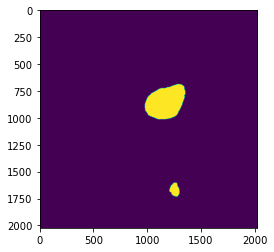

In [10]:
debug = len(df_sample)<2
if debug:
    names,preds = [],[]
    for idx,row in tqdm(df_sample.iterrows(),total=len(df_sample)):

        f = cfg.data_path/'test_images'/f'{idx}.tiff'
        mp = model_pred(path_spleen)
        
        ds = HubmapDataset(f, stats, scale=2, shift=0.8, output_shape=(512,512))
        
        pred = mp.predict(ds) 
        shape = ds.data.shape
        pred = cv2.resize((pred*255).astype('uint8'), (shape[1], shape[0]))
        pred = (pred>cfg.threshold*255).astype(np.uint8)
        
        plt.imshow(pred)
        #convert to rle
    #     #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
        rle = rle_encode_less_memory(pred)
        names.append(str(idx))
        preds.append(rle)
        
        del pred
        gc.collect()
        
    df = pd.DataFrame({'id':names,'rle':preds})
    df.to_csv('submission.csv',index=False)
else:
    names,preds = [],[]
    
    df_hpa = df_sample.query("data_source == 'HPA'")
    for idx,row in df_hpa.iterrows():
        names.append(str(idx))
        rle = ''
        preds.append(rle)
        
    df_hubmap = df_sample.query("data_source == 'Hubmap'")
    
    df_prostate = df_hubmap.query("organ == 'prostate'")
#     for idx,row in df_prostate.iterrows():
#         names.append(str(idx))
#         rle = ''
#         preds.append(rle)
    
    df_spleen = df_hubmap.query("organ == 'spleen'")
    for idx,row in df_spleen.iterrows():
        names.append(str(idx))
        rle = ''
        preds.append(rle)
    
    df_lung = df_hubmap.query("organ == 'lung'")
    for idx,row in df_lung.iterrows():
        names.append(str(idx))
        rle = ''
        preds.append(rle)
        
    df_kidney = df_hubmap.query("organ == 'kidney'")
    for idx,row in df_kidney.iterrows():
        names.append(str(idx))
        rle = ''
        preds.append(rle)
        
    df_largeintestine = df_hubmap.query("organ == 'largeintestine'")
    for idx,row in df_largeintestine.iterrows():
        names.append(str(idx))
        rle = ''
        preds.append(rle)


    
#     predict(path_prostate, df_prostate,sc=1, tile_shape=(160,160))
    
    predict(path_prostate, df_prostate,sc=0.1916, tile_shape=(512,512)) #5.21916667, final picture size is 835
    #training, prostate, use scale 3, 512; use blurred prostate to train
    
#     predict(path_spleen, df_spleen,sc=2, tile_shape=(512,512)) #changed to latest 2*1.2,512
    
#     predict(path_lung, df_lung,sc=1, tile_shape=(512,512)) #when training,use scale 2, 512
#     predict(path_kidney2, df_kidney,sc=3, tile_shape=(512,512)) #can use this scale and tile
#     predict(path_largeintestine, df_largeintestine, sc=3, tile_shape=(512,512)) #need to check shape first

## Use train to test

In [11]:
# df_sample=pd.read_csv('../input/hubmap-organ-segmentation/train.csv', index_col='id')

In [12]:
# # Prostate
# df_prostate = df_sample.query("organ == 'prostate'")
# predict(path_prostate, df_prostate, sc=3, tile_shape=(512,512),train=True)

In [13]:
# # spleen
# df_spleen = df_sample.query("organ == 'spleen'")
# predict(path_spleen, df_spleen,sc=2.4725, tile_shape=(512,512), train=True)

In [14]:
# # kidney
# df_kidney = df_sample.query("organ == 'kidney'")
# predict(path_kidney2, df_kidney,sc=3.75, tile_shape=(512,512), train=True)

In [15]:
# # large_intestine
# df_largeintestine = df_sample.query("organ == 'largeintestine'")
# predict(path_largeintestine, df_largeintestine,sc=1.7175, tile_shape=(512,512), train=True)

In [16]:
# # lung
# df_lung = df_sample.query("organ == 'lung'")
# predict(path_lung, df_lung,sc=1.8905, tile_shape=(512,512), train=True)

In [17]:
df = pd.DataFrame({'id':names,'rle':preds})
df.to_csv('submission.csv',index=False)

In [18]:
# names,preds = [],[]

# mp = model_pred(path_prostate)
# for idx,row in df_prostate.iterrows():

#     f = cfg.data_path/'test_images'/f'{idx}.tiff'
#     #if very small image, use 160 tile
#     if df_prostate.loc[idx].img_height < cfg.tile_shape[0]:
#         ds = HubmapDataset(f, stats, scale=1, shift=0.8, output_shape=(160,160))
#         pred = mp.predict(ds) 
#         shape = ds.data.shape
#         pred = cv2.resize((pred*255).astype('uint8'), (shape[1], shape[0]))
#         pred = (pred>cfg.threshold*255).astype(np.uint8)
#         #convert to rle
#     #     #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#         rle = rle_encode_less_memory(pred)

#         names.append(str(idx))
#         preds.append(rle)

#         del pred
#         gc.collect()
#     #if large image, use 256 tile
#     else:
#         ds = HubmapDataset(f, stats, scale=1, shift=0.8, output_shape=(256,256))
#         pred = mp.predict(ds) 
#         shape = ds.data.shape
#         pred = cv2.resize((pred*255).astype('uint8'), (shape[1], shape[0]))
#         pred = (pred>cfg.threshold*255).astype(np.uint8)
#         #convert to rle
#     #     #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#         rle = rle_encode_less_memory(pred)

#         names.append(str(idx))
#         preds.append(rle)

#         del pred
#         gc.collect()

In [19]:
# from rasterio import Affine
# from rasterio.transform import Affine
# from rasterio.plot import show
# f = '../input/hubmap-organ-segmentation/test_images/10078.tiff'
# data.transform = Affine(2.0, 0.0, 0.0,
#        0.0, 2.0, 0.0)
# data3 = rasterio.open(f, transform = Affine(2., 0., 0., 0., 2., 0.))
# with rasterio.open('../input/hubmap-organ-segmentation/test_images/10078.tiff',
#                    transform=rasterio.Affine(1, 0, 0, 0, 1, 0) ) as d:
#     im = d.read()

# #create small tiff
# with rasterio.open('../input/hubmap-organ-segmentation/test_images/10078.tiff') as d:
#     im = d.read(window=Window.from_slices((1,100),(1,100)))
# from rasterio import Affine
# d.meta
# meta={'driver': 'GTiff',
#  'dtype': 'uint8',
#  'nodata': None,
#  'width': 100,
#  'height': 100,
#  'count': 3,
#  'crs': None,
#  'transform': Affine(1.0, 0.0, 0.0,0.0, 1.0, 0.0)}
# from rasterio.plot import show
# show(im)
# with rasterio.open('10078_small.tiff','w',**meta) as dst:
#                 dst.write(im)


# # Test small img in hubmapdataset
# f = '../input/small-tiff/10078_small.tiff'
# ds = HubmapDataset(f,stats,scale=0.2, output_shape=(120,120))
# len(ds)
# for img, idx in iter(ds):
#     show(img.numpy())
#     print(img.shape)
